In [24]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from numpy import linalg as LA
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
import community.community_louvain as louvain
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.cm as cm
import community

In [25]:
df = pd.read_csv("world_trade_flows2.csv")

graph_list = dict() # dictionary that maps year to the trade network for that year

# initialize a graph for each year in the dictionary
for year in df["year"].unique():
    graph_list[year] = nx.DiGraph()

for i, row in df.iterrows():
    if not row["importer"] == row["exporter"]: 
        graph_list[df["year"][i]].add_edge(row["importer"], row["exporter"], weight=row["tot_trade"])
        
    

In [26]:
# obtain the eigencentrality scores of each node of each year
eigencentralities = dict()

for year in graph_list:
    eigencentralities[year] = nx.eigenvector_centrality(graph_list[year], weight="weight")
    
print(eigencentralities)

{1984: {'Afghanistan': 0.00028319044204329287, 'Australia': 0.06728218067790499, 'Austria': 0.02816976919123964, 'Bangladesh': 0.001946315755507922, 'Belgium-Luxembourg': 0.10162016482390833, 'Brazil': 0.07764342297189342, 'Canada': 0.4235907740559357, 'Switzerland': 0.0651521777443497, 'Czechoslovakia': 0.007581976754481688, 'Fmr Fed. Rep. of Germany': 0.279069484326374, 'Denmark': 0.03195371906827215, 'Egypt': 0.00878618658010346, 'Spain': 0.04449287554682909, 'Finland': 0.021891841929836897, 'France': 0.16921465480090708, 'United Kingdom': 0.19600821901144025, 'Greece': 0.010147008197347596, 'China, Hong Kong SAR': 0.0805521415989718, 'Hungary': 0.0070850485319220525, 'India': 0.028424165316395054, 'Ireland': 0.021908225315794456, 'Italy': 0.14038520550842654, 'Japan': 0.4649049977171624, 'Rep. of Korea': 0.09794498020803812, 'Sri Lanka': 0.003117107594083493, 'Malaysia': 0.04939531039172418, 'Netherlands': 0.13933529801765815, 'Norway': 0.04437183998084026, 'New Zealand': 0.0140955

In [126]:
# Time to generate the ARIMA model (first example is for the USA)
dates = pd.date_range(start="1984", end="2017", freq="Y")
scores = list()
for year in eigencentralities:
    scores.append(eigencentralities[year]["China"]) # country can be changed
    
# Create a dataframe to store these values
df_eigencentrality = pd.DataFrame(scores, index=dates, columns=["Eigencentrality"]) # merge this data for regression analysis later

In [115]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    
    # Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index=["Test Statistic","p-value","#Lags Used","Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    print(dfoutput)

check_stationarity(df_eigencentrality["Eigencentrality"])
    

Results of Dickey-Fuller Test:
Test Statistic                 -0.803718
p-value                         0.818027
#Lags Used                      0.000000
Number of Observations Used    32.000000
Critical Value (1%)            -3.653520
Critical Value (5%)            -2.957219
Critical Value (10%)           -2.617588
dtype: float64


In [116]:
# Since p-value > 0.05
df_eigencentrality["Eigencentrality_diff"] = df_eigencentrality["Eigencentrality"] - df_eigencentrality["Eigencentrality"].shift(1)
df_eigencentrality.dropna(inplace=True)

check_stationarity(df_eigencentrality["Eigencentrality_diff"])

Results of Dickey-Fuller Test:
Test Statistic                 -4.596405
p-value                         0.000131
#Lags Used                      0.000000
Number of Observations Used    31.000000
Critical Value (1%)            -3.661429
Critical Value (5%)            -2.960525
Critical Value (10%)           -2.619319
dtype: float64


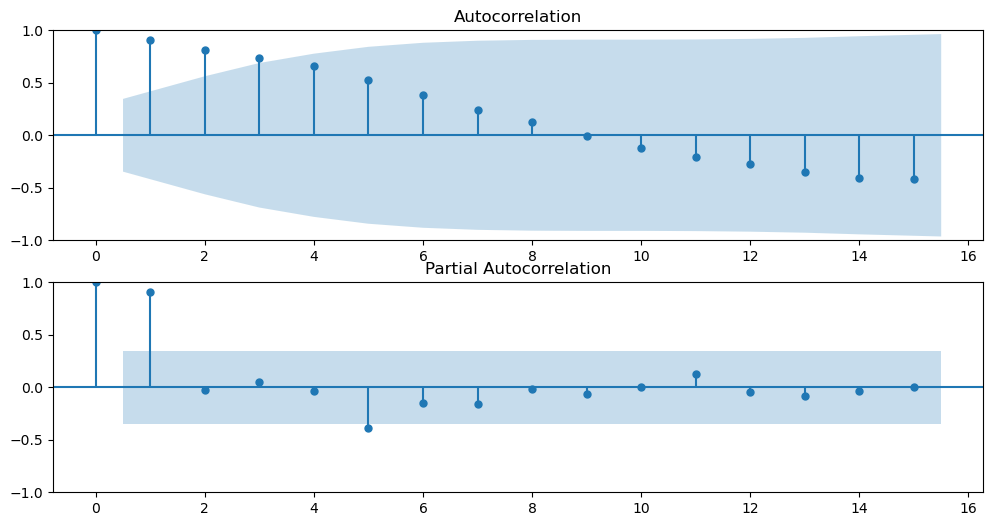

In [117]:
# Now that the difference has made the p-value very small (~0.000131), determine p and q
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

series = df_eigencentrality["Eigencentrality"]
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(series, ax=ax[0], lags=15)
ax[1] = plot_pacf(series, ax=ax[1], lags=15)
plt.show()

# these graphs suggest p = 2 and q = 9 (for China use q=11, Switzerland use q=7)

In [118]:
import pmdarima as pm

series = df_eigencentrality["Eigencentrality"]

# Fit your model
model = pm.auto_arima(series, seasonal=False, trace=True,
                      error_action='ignore', suppress_warnings=True)

# Print the model summary
print(model.summary())

# here is suggests that we use p = 0 and q = 0 (which isn't bad, even though it may seem so... no autoregressive/current error not affected by previous errors)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-140.581, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-148.026, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-146.529, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-146.566, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-148.599, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-144.158, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.180 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  75.300
Date:                Wed, 24 May 2023   AIC                           -148.599
Time:                        18:10:06   BIC                           -147.165
Sample:                    12-31-1985   HQIC                          -148.132
          

In [127]:
# Using (p,d,q) = (2,1,9) (for China q=11, Swizterland q=7)

import statsmodels.api as smapi

# Assume p, d, q are the parameters you have chosen based on your analysis
p = 2
d = 1
q = 11

model = smapi.tsa.arima.ARIMA(df_eigencentrality["Eigencentrality"], order=(p,d,q))
model_fit = model.fit()

/Users/kevincao/.conda/envs/MATH76/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/kevincao/.conda/envs/MATH76/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [128]:
# Generate forecast
forecast = model_fit.get_forecast(steps=10)

forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

print(forecast_values)
print(conf_int)

2017-12-31    0.616561
2018-12-31    0.608361
2019-12-31    0.623603
2020-12-31    0.632722
2021-12-31    0.620722
2022-12-31    0.609770
2023-12-31    0.605215
2024-12-31    0.606682
2025-12-31    0.608393
2026-12-31    0.606931
Freq: A-DEC, Name: predicted_mean, dtype: float64
            lower Eigencentrality  upper Eigencentrality
2017-12-31               0.590305               0.642817
2018-12-31               0.566219               0.650504
2019-12-31               0.562148               0.685057
2020-12-31               0.551520               0.713923
2021-12-31               0.524005               0.717440
2022-12-31               0.491423               0.728118
2023-12-31               0.467831               0.742600
2024-12-31               0.453048               0.760317
2025-12-31               0.440344               0.776441
2026-12-31               0.423068               0.790795


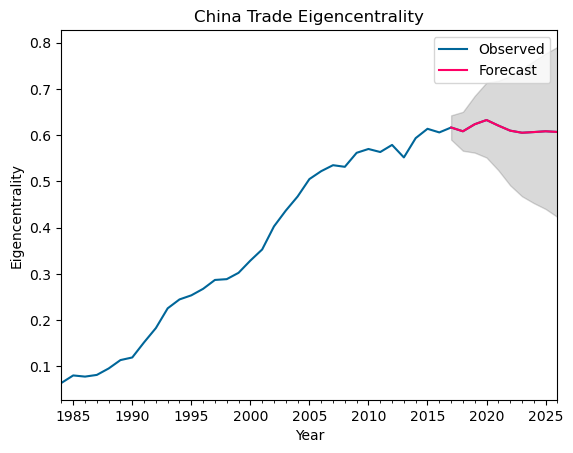

In [129]:
# Plot the forecast
df_forecast = df_eigencentrality

df_temp = pd.DataFrame(forecast_values).rename(columns={"predicted_mean":"Eigencentrality"})
df_temp = df_temp.join(pd.DataFrame(conf_int))

# df_forecast.drop(["Eigencentrality_diff"], axis=1, inplace=True)

df_forecast = pd.concat([df_forecast, df_temp])

df_forecast["Eigencentrality"].plot(label='Observed', color='#006699')
df_temp["Eigencentrality"].plot(label='Forecast', color='#ff0066')

plt.fill_between(df_temp.index, df_temp["lower Eigencentrality"], df_temp["upper Eigencentrality"], color='k', alpha=.15)

plt.title('China Trade Eigencentrality')
plt.xlabel('Year')
plt.ylabel('Eigencentrality')
plt.legend()
plt.show()



/Users/kevincao/.conda/envs/MATH76/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/kevincao/.conda/envs/MATH76/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test RMSE: 0.028
            lower Eigencentrality  upper Eigencentrality
2012-12-31               0.538715               0.590422
2013-12-31               0.529519               0.621546
2014-12-31               0.514096               0.648703
2015-12-31               0.481864               0.664931
2016-12-31               0.446964               0.689728


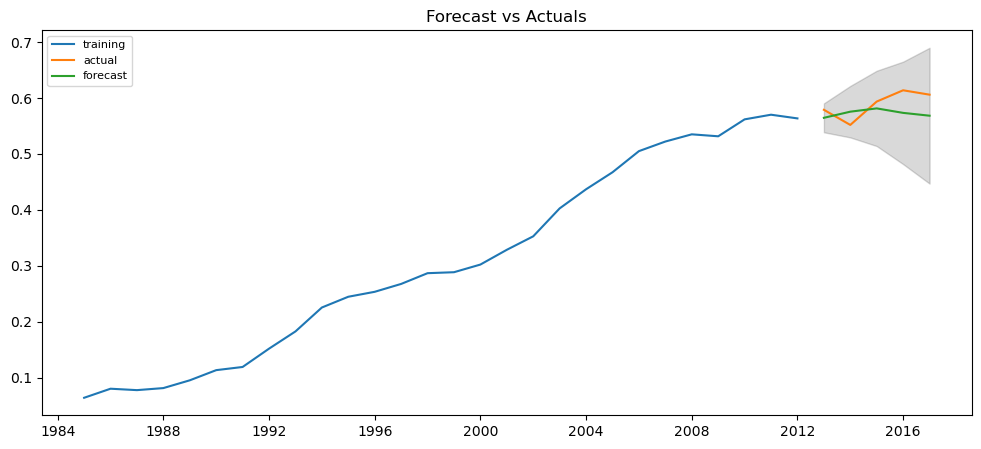

In [130]:
# Testing the robustness of the model

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# splitting the data
end_train_date = pd.to_datetime('2012-01-01')  
start_test_date = end_train_date + pd.DateOffset(days=1)

train = df_eigencentrality[df_eigencentrality.index < end_train_date]
test = df_eigencentrality[df_eigencentrality.index >= start_test_date]

# fitting the model
model = ARIMA(train['Eigencentrality'], order=(2,1,9)) 
model_fit = model.fit()

# making predictions
forecast = model_fit.get_forecast(steps=5)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# calculating RMSE
mse = mean_squared_error(test['Eigencentrality'], forecast_values)

rmse = sqrt(mse)
print('Test RMSE: %.3f' % rmse)

print(conf_int)

# Plotting the original series, forecast, and confidence intervals
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.index, train['Eigencentrality'], label='training')
plt.plot(test.index, test['Eigencentrality'], label='actual')
plt.plot(test.index, forecast_values, label='forecast')
plt.fill_between(test.index, conf_int["lower Eigencentrality"], conf_int["upper Eigencentrality"], color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [39]:
# TODO:
# Plot forecast
# Test on China
# Train-test split by preserving the final 5 years of data as our testing set
# Implement with LSTM 

In [23]:
# Eigencentrality scores for each country of each year

dates = pd.date_range(start="1984", end="2017", freq="Y")
scores = dict()

for year in graph_list:
    scores[year] = dict()


for year in eigencentralities:
    for country in df["exporter"].unique():
        if country in eigencentralities[year]:
            scores[year][country] = eigencentralities[year][country]

KeyError: 'exporter'

In [17]:
# Constructing the eigencentrality dataframe
df = pd.DataFrame(scores)
df = df.stack().reset_index()
df.columns = ["Country", "Year", "Eigencentrality"]



In [18]:
countries_list_wtf = df["Country"].unique()

In [19]:
# Process the Exchange Rate Data
df_ER = pd.read_csv("WS_XRU_csv_col.csv")
df_ER = df_ER[df_ER.Frequency == "Annual"]
df_ER = df_ER[df_ER.Collection == "Average of observations through period"]
df_ER = df_ER.drop(["FREQ", "REF_AREA", "UNIT_MULT", "Unit Multiplier", "DECIMALS", "Decimals", "Availability", "TITLE", "Series"], axis=1)
df_ER = df_ER.drop(["COLLECTION", "Collection", "AVAILABILITY"], axis=1)
df_ER.drop(["Frequency"], axis=1, inplace=True)

for (column_name, column_items) in df_ER.iteritems():
    if "-" in column_name:
        df_ER.drop([column_name], axis=1, inplace=True)
        
for (column_name, column_items) in df_ER.iteritems():
    if column_name.isnumeric() and int(column_name) < 1984:
        df_ER.drop([column_name], axis=1, inplace=True)
        
df_ER = df_ER.replace({"Netherlands Antilles": "Neth. Antilles", "Bosnia and Herzegovina": "Bosnia Herzegovina",
                             "Brunei": "Brunei Darussalam", "Bolivia":"Bolivia (Plurinational State of)",
                             "Congo Democratic Republic":"Congo", "Central African Republic":"Central African Rep.",
                             "Cote d'Ivoire":"Côte d'Ivoire", "Dominican Republic":"Dominican Rep.","Micronesia":"FS Micronesia",
                             "Hong Kong SAR":"China, Hong Kong SAR", "Kyrgyz Republic":"Kyrgyzstan", "St.Kitts - Nevis":"Saint Kitts and Nevis",
                             "Korea":"Rep. of Korea","Cayman Islands":"Cayman Isds","Laos":"Lao People's Dem. Rep.",
                             "St. Lucia":"Saint Lucia","Moldova":"Rep. of Moldova", "North Macedonia":"TFYR of Macedonia",
                             "Macao SAR":"China, Macao SAR","Russia":"Russian Federation","Eswatini":"Swaziland",
                             "Chinese Taipei":"Taiwan", "Tanzania":"United Rep. of Tanzania","United States":"USA",
                             "St. Vincent and the Grenadines":"Saint Vincent and the Grenadines",
                             "Vietnam":"Viet Nam"})

df_ER = df_ER.rename(columns={"Reference area": "Country"})

df_ER = df_ER[df_ER.Country != "Waemu"]
df_ER = df_ER[df_ER.Country != "Euro area"]
df_ER = df_ER[df_ER.Country != "World"]

df_ER = df_ER.reset_index()
df_ER.drop(["index"], axis=1, inplace=True)

temp = dict()

for i in range(1984, 2017):
    temp[i] = dict()
    
for i, row in df_ER.iterrows():
    for year in range(1984, 2017):
        temp[year][df_ER["Country"][i]] = df_ER[str(year)][i]
    
df_ER = pd.DataFrame(temp)
df_ER = df_ER.stack().reset_index()
df_ER.columns = ["Country", "Year", "E_USD"]

/var/folders/5m/nw7wt55x46v9lm322x4fhb2r0000gn/T/ipykernel_77886/796043178.py:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (column_name, column_items) in df_ER.iteritems():
/var/folders/5m/nw7wt55x46v9lm322x4fhb2r0000gn/T/ipykernel_77886/796043178.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (column_name, column_items) in df_ER.iteritems():


In [20]:
# Merge the exchange rate data into the eigencentrality data 

df_countries = df["Country"].unique()
df_ER_countries = df_ER["Country"].unique()

drop = list()
for country in df_ER_countries:
    if country not in df_countries:
        drop.append(country)
        
print(drop)






print(df["Country"].unique())
print(df["Country"])
print(df_ER["Country"])

['Solomon Islands']
['Australia' 'Austria' 'Bangladesh' 'Belgium-Luxembourg' 'Brazil' 'Canada'
 'Switzerland' 'Czechoslovakia' 'Fmr Fed. Rep. of Germany' 'Denmark'
 'Egypt' 'Spain' 'Finland' 'France' 'United Kingdom' 'Greece'
 'China, Hong Kong SAR' 'Hungary' 'India' 'Ireland' 'Italy' 'Japan'
 'Rep. of Korea' 'Sri Lanka' 'Malaysia' 'Netherlands' 'Norway'
 'New Zealand' 'Pakistan' 'Poland' 'Portugal' 'Singapore' 'Sweden'
 'Thailand' 'Tunisia' 'USA' 'Argentina' 'Congo' 'Cape Verde' 'Indonesia'
 'Kenya' 'Morocco' 'Paraguay' 'Syria' 'Uruguay' 'Venezuela' 'Zimbabwe'
 'Barbados' 'Jamaica' 'Algeria' 'Peru' 'Chile' 'Colombia' 'Ecuador'
 'Guadeloupe' 'Grenada' 'French Guiana' 'China, Macao SAR' 'Martinique'
 'Philippines' 'Trinidad and Tobago' 'Afghanistan' 'Albania' 'Taiwan'
 'Burundi' 'Bulgaria' 'Bahrain' 'Bolivia (Plurinational State of)' 'China'
 "Côte d'Ivoire" 'Dem. Rep. of the Congo' 'Costa Rica' 'Cuba' 'Cyprus'
 'Fmr Dem. Rep. of Germany' 'Djibouti' 'Dominican Rep.' 'Fmr Ethiopia'
 'Fij

In [21]:





# rename
# Netherlands Antilles -> Neth. Antilles
# Bosnia and Herzegovina -> Bosnia Herzegovina
# Brunei -> Brunei Darussalam
# Bolivia -> Bolivia (Plurinational State of)
# Congo Democratic Republic -> Congo
# Central African Republic -> Central African Rep.
# Cote d'Ivoire -> Côte d'Ivoire
# Dominican Republic -> Dominican Rep.
# Micronesia -> FS Micronesia
# Hong Kong SAR -> China, Hong Kong SAR
# Kyrgyz Republic -> Kyrgyzstan
# St.Kitts - Nevis -> Saint Kitts and Nevis
# Korea -> Rep. of Korea
# Cayman Islands -> Cayman Isds
# Laos -> Lao People's Dem. Rep.
# St. Lucia -> Saint Lucia
# Moldova -> Rep. of Moldova
# North Macedonia -> TFYR of Macedonia
# Macao SAR -> China, Macao SAR
# Russia -> Russian Federation
# Eswatini -> Swaziland
# Chinese Taipei -> Taiwan
# Tanzania -> United Rep. of Tanzania
# United States -> USA
# St. Vincent and the Grenadines -> Saint Vincent and the Grenadines
# Vietnam -> Viet Nam
# drop WAEMU, Euro, and World

In [22]:
# rename
# Netherlands Antilles -> Neth. Antilles
# Bosnia and Herzegovina -> Bosnia Herzegovina
# Brunei -> Brunei Darussalam
# Bolivia -> Bolivia (Plurinational State of)
# Congo Democratic Republic -> Congo
# Central African Republic -> Central African Rep.
# Cote d'Ivoire -> Côte d'Ivoire
# Dominican Republic -> Dominican Rep.
# Micronesia -> FS Micronesia
# Hong Kong SAR -> China, Hong Kong SAR
# Kyrgyz Republic -> Kyrgyzstan
# St.Kitts - Nevis -> Saint Kitts and Nevis
# Korea -> Rep. of Korea
# Cayman Islands -> Cayman Isds
# Laos -> Lao People's Dem. Rep.
# St. Lucia -> Saint Lucia
# Moldova -> Rep. of Moldova
# North Macedonia -> TFYR of Macedonia
# Macao SAR -> China, Macao SAR
# Russia -> Russian Federation
# Eswatini -> Swaziland
# Chinese Taipei -> Taiwan
# Tanzania -> United Rep. of Tanzania
# United States -> USA
# St. Vincent and the Grenadines -> Saint Vincent and the Grenadines
# Vietnam -> Viet Nam
# drop WAEMU, Euro, and World